In [1]:
# import packages

# Basics
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Graphs
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Preprocessing; model selection and evaluation
from sklearn import pipeline, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# text handling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm

# for custom countvectorizer with SpaCy lemmatization
import spacy
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, VectorizerMixin
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix

# WordCloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

------
If we need to move virtual ENV to use Tensorflow we will need to install:

1. spacy

<code> conda install -c spacy spacy </code>

2. 'en_core_web_md' (maybe?)

<code> python -m spacy download en_core_web_md </code>

3. wordcloud (maybe?)

&emsp;Google wordcloud anaconda

------

In [2]:
# import packages
data = pd.read_csv("saved_csv/df.csv")
data.drop(columns = "Unnamed: 0",inplace=True)

df = data.copy()

### Setting up data for analysis
------

In [3]:
# fixing some column names
df.rename(columns = {df.columns[5] : "Does your employer provide mental health benefits as part of healthcare coverage?"}, inplace=True)

In [4]:
# putting questions into categories

current_mh_coverage = ["Does your employer provide mental health benefits as part of healthcare coverage?",
               "Do you know the options for mental health care available under your employer-provided health coverage?",
               "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",
               "Does your employer offer resources to learn more about mental health disorders and options for seeking help?",
               "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?",
               "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?"]

previous_mh_coverage = ["Have your previous employers provided mental health benefits?",
                        "Were you aware of the options for mental health care provided by your previous employers?",
                        "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?",
                        "Did your previous employers provide resources to learn more about mental health disorders and how to seek help?",
                        "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?"]

mh_status = ["Do you currently have a mental health disorder?",
             "Have you ever been diagnosed with a mental health disorder?",'Anxiety Disorder', 'Mood Disorder', 
             'Psychotic Disorder','Eating Disorder', 'Neurodevelopmental Disorders','Personality Disorder', 
             'Obsessive-Compulsive Disorder','Post-Traumatic Stress Disorder', 'Dissociative Disorder',
             'Substance-Related and Addictive Disorders', 'Other','Adjustment disorder',
             "Have you had a mental health disorder in the past?",
             "Have you ever sought treatment for a mental health disorder from a mental health professional?",
             "Do you have a family history of mental illness?",
             "How willing would you be to share with friends and family that you have a mental illness?",
             "Would you be willing to bring up a physical health issue with a potential employer in an interview?"]

witnessed_exp = ["Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?",
                 "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?",
                 "Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?"]

ratings = df.columns[df.columns.str.contains("Overall")]

demographics = ["What is your age?","What is your gender?","What country do you live in?",
                "What US state or territory do you live in?","What is your race?"]

comfort_talking_current = ["Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?",
                           "Have you ever discussed your mental health with your employer?",
                           "Would you feel comfortable discussing a mental health issue with your coworkers?",
                           "Have you ever discussed your mental health with coworkers?",
                           "Have you ever had a coworker discuss their or another coworker's mental health with you?",
                           "Would you feel more comfortable talking to your coworkers about your physical health or your mental health?",
                           "Would you bring up your mental health with a potential employer in an interview?",
                           "Are you openly identified at work as a person with a mental health issue?"]

comfort_talking_previous = ["Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?",
                            "Would you have been willing to discuss your mental health with your direct supervisor(s)?",
                            "Did you ever discuss your mental health with your previous employer?",
                            "Would you have been willing to discuss your mental health with your coworkers at previous employers?",
                            "Did you ever discuss your mental health with a previous coworker(s)?",
                            "Did you ever have a previous coworker discuss their or another coworker's mental health with you?",
                            "Would you bring up your mental health with a potential employer in an interview?",
                            "Are you openly identified at work as a person with a mental health issue?"]

comfort_dependent_var = ["Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?",
                           "Have you ever discussed your mental health with your employer?",
                           "Would you feel comfortable discussing a mental health issue with your coworkers?",
                           "Have you ever discussed your mental health with coworkers?",
                           "Have you ever had a coworker discuss their or another coworker's mental health with you?",
                           "Would you feel more comfortable talking to your coworkers about your physical health or your mental health?",
                           "Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?",
                           "Would you have been willing to discuss your mental health with your direct supervisor(s)?",
                           "Did you ever discuss your mental health with your previous employer?",
                           "Would you have been willing to discuss your mental health with your coworkers at previous employers?",
                           "Did you ever discuss your mental health with a previous coworker(s)?",
                           "Did you ever have a previous coworker discuss their or another coworker's mental health with you?",
                           "Would you bring up your mental health with a potential employer in an interview?",
                           "Are you openly identified at work as a person with a mental health issue?"]

categories = [current_mh_coverage,previous_mh_coverage,mh_status,witnessed_exp,ratings,comfort_talking_current,comfort_talking_previous,comfort_dependent_var]

### Preparing the data
------

#### Independent Variables for Q1
------

In [5]:
def make_dummies_q(question,num):
    '''
    This function creates dummy variable for text responses.
    It also creates a table of answers that are omitted in the table in preparation for analysis,
        since n-1 answer for each question is needed to avoid multicollinearity.
        
    Returns:
    -------
    question_omitted: a table with question and the answer that has been omitted to avoid multicollinearity.
    result: a table of dummy variables.
    '''
    d = {}
    question_omitted = pd.DataFrame(columns = ["Question","Answer"])
    result = pd.DataFrame()

    d[num] = pd.get_dummies(df_2.loc[:,question])
    question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[0]},ignore_index = True)
    d[num].drop(columns = d[num].columns[0],inplace = True)

    for i in range(len(d[num].columns)):
        name = question + "__" + d[num].columns[i]
        d[num].rename(columns = {d[num].columns[i] : name},inplace=True)

    result = pd.concat([result,d[num]],axis=1)
        
    return question_omitted,result

In [6]:
def make_dummies_special(question,answer = "Yes",drop_column_num = 3):
    
    question_omitted = pd.DataFrame(columns = ["Question","Answer"])
    
    dummies = pd.get_dummies(df_2.loc[:,question])
    question_omitted = question_omitted.append({"Question":question, "Answer": answer},ignore_index = True)
    dummies.drop(columns=dummies.columns[drop_column_num],inplace=True)
    for j in range(len(dummies.columns)):
        name = question + "__" + dummies.columns[j]
        dummies.rename(columns = {dummies.columns[j] : name},inplace=True)
    
    return question_omitted,dummies

In [7]:
def make_dummies_special2(question,columns_to_keep = 1):
    
    dummies = pd.get_dummies(df_2.loc[:,question])
    for j in range(len(dummies.columns)):
        name = question + "__" + dummies.columns[j]
        dummies.rename(columns = {dummies.columns[j] : name},inplace=True)

    result = dummies.iloc[:,[columns_to_keep]]
    
    return result

In [8]:
# making a copy
df_2 = df.copy()

In [9]:
# preparing a table of independent variables for Q1
independent_var = [current_mh_coverage,previous_mh_coverage,witnessed_exp,mh_status,ratings]
dependent_var = [comfort_talking_current,comfort_talking_previous]

In [10]:
# need to clean up some data first
df_2.loc[:,current_mh_coverage[0]][df_2.loc[:,current_mh_coverage[0]]=="Not Applicable"]=\
"Not eligible for coverage / NA"

df_2.loc[:,current_mh_coverage[1]][df_2.loc[:,current_mh_coverage[1]]=="Did not answer"]="Not Applicable"

In [11]:
# set up 2 dataframes for concatenating data
omitted = pd.DataFrame(columns = ["Question","Answer"])
final = pd.DataFrame()

In [12]:
#current_mh_coverage

In [13]:
# current_mh_coverage
for i in [0,2,3]:
    result = make_dummies_special2(current_mh_coverage[i],-1)
    final = pd.concat([final,result],axis = 1)

for i in [2,-2,-1]:
    result = make_dummies_special2(current_mh_coverage[5],i)
    final = pd.concat([final,result],axis = 1)

In [14]:
# previous_mh_coverage

# dummies = pd.get_dummies(df_2.loc[:,previous_mh_coverage[3]])
# dummies

# for i in [-2,-1]:
#     result = make_dummies_special2(previous_mh_coverage[j],i)
#     final = pd.concat([final,result],axis = 1)

# for i in [1,-1]:
#     result = make_dummies_special2(previous_mh_coverage[1],i)
#     final = pd.concat([final,result],axis = 1)

# for i in [-2,-1]:
#     result = make_dummies_special2(previous_mh_coverage[2],i)
#     final = pd.concat([final,result],axis = 1)

# for i in [-2,-1]:
#     result = make_dummies_special2(previous_mh_coverage[3],i)
#     final = pd.concat([final,result],axis = 1)

# for i in [-2,-1]:
#     result = make_dummies_special2(previous_mh_coverage[4],i)
#     final = pd.concat([final,result],axis = 1)

In [15]:
# clean up some responses in witnessed_exp
df_2.loc[:,witnessed_exp[1]][df_2.loc[:,witnessed_exp[1]]=="Yes, I experienced"]="Yes, I observed"
df_2.loc[:,witnessed_exp[1]][df_2.loc[:,witnessed_exp[1]]=="Yes, I observed"]="Yes"

df_2.loc[:,witnessed_exp[2]][df_2.loc[:,witnessed_exp[2]]=="Yes, I experienced"]="Yes, I observed"
df_2.loc[:,witnessed_exp[2]][df_2.loc[:,witnessed_exp[2]]=="Yes, I observed"]="Yes"

#witnessed_exp

In [16]:
# witnessed_exp

result = make_dummies_special2(witnessed_exp[0],-1)
final = pd.concat([final,result],axis = 1)

# can we fit more questions in?

In [17]:
# mh_status
to_dummy = []
for i in [0,1,-5,-3,-1]:
    to_dummy.append(mh_status[i])
    
df_2.loc[:,to_dummy[0]][df_2.loc[:,to_dummy[0]]=="Possibly"]="Don't Know"

df_2.loc[:,to_dummy[2]][df_2.loc[:,to_dummy[2]]=="Possibly"]="Don't Know"
df_2.loc[:,to_dummy[2]][df_2.loc[:,to_dummy[2]]=="-1"]="Don't Know"

In [18]:
#to_dummy

In [19]:
#mh_status

In [20]:
# mh_status
result = make_dummies_special2(to_dummy[0],-1)
final = pd.concat([final,result],axis = 1)

for i in [2,3,4,5,6,7,8,9,10,11,12,13,15,17]:
    final = pd.concat([final,df_2.loc[:,mh_status[i]]],axis = 1)

In [21]:
#ratings

In [22]:
# ratings
for i in [1,4]:
    final = pd.concat([final,df_2.loc[:,ratings[i]]],axis = 1)

In [23]:
independent_q1 = final

In [24]:
independent_q1.head()

,Does your employer provide mental health benefits as part of healthcare coverage?__Yes,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?__Yes",Does your employer offer resources to learn more about mental health disorders and options for seeking help?__Yes,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Neither easy nor difficult","If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Somewhat easy","If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Very easy",Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?__Yes,Do you currently have a mental health disorder?__Yes,Anxiety Disorder,Mood Disorder,Psychotic Disorder,Eating Disorder,Neurodevelopmental Disorders,Personality Disorder,Obsessive-Compulsive Disorder,Post-Traumatic Stress Disorder,Dissociative Disorder,Substance-Related and Addictive Disorders,Other,Adjustment disorder,Have you ever sought treatment for a mental health disorder from a mental health professional?,How willing would you be to share with friends and family that you have a mental illness?,"Overall, how much importance does your employer place on mental health?","Overall, how well do you think the tech industry supports employees with mental health issues?"
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5,0.0,1.0
1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,2.0,2.0
2,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1,5,1.0,1.0
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,10,5.0,2.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,5.0,1.0


#### Dependent Variables for Q1
------

In [25]:
def make_dummies(category_list, drop_num = 1):
    '''
    This function creates dummy variable for text responses.
    It also creates a table of answers that are omitted in the table in preparation for analysis,
        since n-1 answer for each question is needed to avoid multicollinearity.
        
    Returns:
    -------
    question_omitted: a table with question and the answer that has been omitted to avoid multicollinearity.
    result: a table of dummy variables.
    '''
    d = {}
    question_omitted = pd.DataFrame(columns = ["Question","Answer"])
    result = pd.DataFrame()

    for num,question in enumerate(category_list):
        d[num] = pd.get_dummies(dependent.loc[:,question])
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[drop_num]},ignore_index = True)
        d[num].drop(columns = d[num].columns[drop_num],inplace = True)

        for i in range(len(d[num].columns)):
            name = question + "__" + d[num].columns[i]
            d[num].rename(columns = {d[num].columns[i] : name},inplace=True)

        result = pd.concat([result,d[num]],axis=1)
        
    return question_omitted,result

In [26]:
def make_dummies_q(question,num,drop_pattern = 1):
    '''
    This function creates dummy variable for text responses.
    It also creates a table of answers that are omitted in the table in preparation for analysis,
        since n-1 answer for each question is needed to avoid multicollinearity.
        
    Returns:
    -------
    question_omitted: a table with question and the answer that has been omitted to avoid multicollinearity.
    result: a table of dummy variables.
    '''
    d = {}
    question_omitted = pd.DataFrame(columns = ["Question","Answer"])
    result = pd.DataFrame()

    d[num] = pd.get_dummies(dependent.loc[:,question])
    if drop_pattern == 1:
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[0]},ignore_index = True)
        d[num].drop(columns = d[num].columns[0],inplace = True)
    elif drop_pattern == 2:
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[-1]},ignore_index = True)
        d[num].drop(columns = d[num].columns[-1],inplace = True)
    elif drop_pattern == 3:
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[-2]},ignore_index = True)
        d[num].drop(columns = d[num].columns[-2],inplace = True)

    for i in range(len(d[num].columns)):
        name = question + "__" + d[num].columns[i]
        d[num].rename(columns = {d[num].columns[i] : name},inplace=True)

    result = pd.concat([result,d[num]],axis=1)
        
    return question_omitted,result

In [27]:
# creating a table of dependent variables
dependent = df.loc[:,comfort_dependent_var]
#dependent.head()

In [28]:
#dependent
#Questions to dummies: 0,2,5,6,7,9,12
#Responses: 0,0,-1,-1,-2,-2
#The rest: 1,3,4,8,10,11,13

In [29]:
omitted_dep = pd.DataFrame(columns = ["Question","Answer"])
final_dep = pd.DataFrame()

for i in [0,2]:
    question_omitted,result = make_dummies_q(dependent.columns[i],i,drop_pattern = 1)
    final_dep = pd.concat([final_dep,result],axis = 1)
    omitted_dep = omitted_dep.append(question_omitted,ignore_index = True)

for i in [5,6]:
    question_omitted,result = make_dummies_q(dependent.columns[i],i,drop_pattern = 2)
    final_dep = pd.concat([final_dep,result],axis = 1)
    omitted_dep = omitted_dep.append(question_omitted,ignore_index = True)

for i in [9,12]:
    question_omitted,result = make_dummies_q(dependent.columns[i],i,drop_pattern = 3)
    final_dep = pd.concat([final_dep,result],axis = 1)
    omitted_dep = omitted_dep.append(question_omitted,ignore_index = True)
    
for i in [1,3,4,8,10,11,13]:
    result = pd.get_dummies(dependent.iloc[:,i])
    result.drop(columns = result.columns[-1],inplace = True)
    final_dep = pd.concat([final_dep,result],axis = 1)

In [30]:
final_dep.head()

,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?__No,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?__Not Applicable,Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?__Yes,Would you feel comfortable discussing a mental health issue with your coworkers?__No,Would you feel comfortable discussing a mental health issue with your coworkers?__Not Applicable,Would you feel comfortable discussing a mental health issue with your coworkers?__Yes,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?__Mental health,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?__Not Applicable,Would you feel more comfortable talking to your coworkers about your physical health or your mental health?__Physical health,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?__Did not answer,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?__Mental health,Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?__Physical health,Would you have been willing to discuss your mental health with your coworkers at previous employers?__Did not answer,"Would you have been willing to discuss your mental health with your coworkers at previous employers?__No, at none of my previous employers","Would you have been willing to discuss your mental health with your coworkers at previous employers?__Yes, at all of my previous employers",Would you bring up your mental health with a potential employer in an interview?__Maybe,Would you bring up your mental health with a potential employer in an interview?__Yes,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1
1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,1
4,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1


#### Predicting classes
------

Models considered:

- GMM
- KMeans Clustering
- Agglomerative Clustering

In [31]:
# GMM
X_alt = final_dep

my_gmm = GaussianMixture(n_components=4,covariance_type='full')
my_gmm.fit(X_alt)

y_pred_alt = my_gmm.predict(X_alt)

a_alt = pd.DataFrame(y_pred_alt)
print(a_alt[0].groupby(a_alt[0]).count())

0
0    169
1    696
2    180
3    128
Name: 0, dtype: int64


In [32]:
# KMeans Clustering
k_means_model = KMeans(n_clusters = 4)
k_means_model.fit(X_alt)

y_pred2_alt = k_means_model.predict(X_alt)

b_alt = pd.DataFrame(y_pred2_alt)
b_alt[0].groupby(b_alt[0]).count()

0
0    128
1    169
2    402
3    474
Name: 0, dtype: int64

In [33]:
# Agglomerative Clustering
X_alt = final_dep

model = AgglomerativeClustering(n_clusters=4)
y_pred3_alt = model.fit_predict(X_alt)

c_alt = pd.DataFrame(y_pred3_alt)
c_alt[0].groupby(c_alt[0]).count()

0
0    418
1    458
2    128
3    169
Name: 0, dtype: int64

In [34]:
#b_alt.rename(columns = {0 : "Classes"},inplace=True)

In [35]:
#b_alt.to_csv("saved_csv/q1_dependent_alt.csv")

### Q1 - Factors that affect comfort level in discussing MH at workplace
------

In [36]:
def make_dummies_q(question,num,drop_pattern = 1):
    '''
    This function creates dummy variable for text responses.
    It also creates a table of answers that are omitted in the table in preparation for analysis,
        since n-1 answer for each question is needed to avoid multicollinearity.
        
    Returns:
    -------
    question_omitted: a table with question and the answer that has been omitted to avoid multicollinearity.
    result: a table of dummy variables.
    '''
    d = {}
    question_omitted = pd.DataFrame(columns = ["Question","Answer"])
    result = pd.DataFrame()

    d[num] = pd.get_dummies(df_2.loc[:,question])
    if drop_pattern == 1:
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[-2]},ignore_index = True)
        d[num].drop(columns = d[num].columns[0],inplace = True)
    elif drop_pattern == 2:
        question_omitted = question_omitted.append({"Question":question, "Answer": d[num].columns[3]},ignore_index = True)
        d[num].drop(columns = d[num].columns[3],inplace = True)

    for i in range(len(d[num].columns)):
        name = question + "__" + d[num].columns[i]
        d[num].rename(columns = {d[num].columns[i] : name},inplace=True)

    result = pd.concat([result,d[num]],axis=1)
        
    return question_omitted,result

In [37]:
# grabbing the dependent variables
dependent_class = pd.read_csv("saved_csv/q1_dependent_alt.csv")
dependent_class.drop('Unnamed: 0',axis=1,inplace=True)
#dependent_class

In [38]:
# need to add -8 - What is your age?

# What is your gender?
question_omitted,gender = make_dummies_q(df_2.columns[-7],-7,drop_pattern = 2)

In [39]:
# Grouping countries into 5 continents
country_names = df_2.iloc[:,-6].groupby(df_2.iloc[:,-6]).count().index

df_2["countries_continent"] = df_2.iloc[:,-6]

north_am = [8,34,55]
south_am = [0,6,9,56]
asia = [3,20,23,24,26,28,29,39,43,44,46]
africa = [14,30,33,37,48]
europe = [2,4,5,7,10,11,13,15,16,17,18,19,21,22,25,27,31,32,35,38,40,41,42,45,47,49,50,51,52,53,54]
oceania = [1,36]
did_not_answer = [12]

continents = [north_am,south_am,asia,africa,europe,oceania,did_not_answer]
names = ["North America", "South America", "Asia", "Africa", "Europe", "Oceania", "Did not answer"]

for position,continent in enumerate(continents):
    for num in np.flip(continent):
        df_2.loc[:,"countries_continent"][df_2.loc[:,"countries_continent"]== country_names[num]]=names[position]

In [40]:
countries = df_2.iloc[:,-1]

In [41]:
countries = pd.get_dummies(countries)
countries.drop(columns = "North America", inplace=True)

In [42]:
# What is your race?
races = pd.get_dummies(df_2.iloc[:,-5])
races.drop(columns = "Caucasian", inplace=True)

In [43]:
independent_q1_alt = pd.concat([independent_q1,gender,countries,races,df.iloc[:,-8]],axis=1)

In [44]:
#independent_q1_alt.head()

In [45]:
# p-value WITHOUT DEMOGRAPHICS

X_1 = independent_q1
Y_1 = dependent_class/3

scaler = preprocessing.StandardScaler()
scaler.fit(X_1)
X_transformed_1 = scaler.transform(X_1)

X_transformed_1 = np.hstack([np.ones([X_transformed_1.shape[0],1]), X_transformed_1])

logit = sm.Logit(Y_1, X_transformed_1)
fitted_model_1 = logit.fit()
fitted_model_1.summary()

# alpha = 0.05

Optimization terminated successfully.
         Current function value: 0.642501
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Classes   No. Observations:                 1173
Model:                          Logit   Df Residuals:                     1148
Method:                           MLE   Df Model:                           24
Date:                Mon, 18 Mar 2019   Pseudo R-squ.:                 0.07265
Time:                        15:18:17   Log-Likelihood:                -753.65
converged:                       True   LL-Null:                       -812.70
                                        LLR p-value:                 2.126e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0300      0.060      0.497      0.619      -0.088       0.148
x1            -0.1914      0.071     -2.698      0.007      -0.330      -0.052
x2            -0.0863      0.077     -1.114      0.265      -0.238       0.066
x3            -0.0830      0.080     -1.044      0.297      -0.239       0.073
x4            -0.1769      0.065     -2.734      0.006      -0.304      -0.050
x5            -0.1999      0.068     -2.923      0.003      -0.334      -0.066
x6            -0.1614      0.070     -2.317      0.021      -0.298      -0.025
x7             0.0218      0.063      0.347      0.728      -0.101       0.145
x8             0.0111      0.088      0.125      0.900      -0.162       0.184
x9            -0.0059      0.073     -0.082      0.935      -0.148       0.136
x10           -0.0251      0.076     -0.329      0.742      -0.174       0.124
x11           -0.0058      0.061     -0.096      0.924      -0.125       0.113
x12           -0.0572      0.063     -0.907      0.365      -0.181       0.066
x13           -0.0511      0.064     -0.796      0.426      -0.177       0.075
x14           -0.1154      0.064     -1.797      0.072      -0.241       0.010
x15           -0.0248      0.063     -0.391      0.696      -0.149       0.099
x16            0.0176      0.065      0.272      0.786      -0.109       0.145
x17            0.0207      0.064      0.322      0.748      -0.105       0.147
x18            0.0906      0.063      1.434      0.151      -0.033       0.214
x19            0.0469      0.068      0.694      0.488      -0.086       0.179
x20            0.0121      0.063      0.191      0.848      -0.112       0.136
x21            0.1883      0.082      2.283      0.022       0.027       0.350
x22            0.1467      0.066      2.220      0.026       0.017       0.276
x23            0.3273      0.071      4.630      0.000       0.189       0.466
x24           -0.0672      0.067     -0.998      0.318      -0.199       0.065
==============================================================================
"""

In [46]:
# p-value WITH DEMOGRAPHICS

X_1 = independent_q1_alt
Y_1 = dependent_class/3

scaler = preprocessing.StandardScaler()
scaler.fit(X_1)
X_transformed_1 = scaler.transform(X_1)

X_transformed_1 = np.hstack([np.ones([X_transformed_1.shape[0],1]), X_transformed_1])

logit = sm.Logit(Y_1, X_transformed_1)
fitted_model_demo = logit.fit()
fitted_model_demo.summary()

# alpha = 0.05
# all features together are significant
# Columns that are significant: 0,3,4,5,21,22

         Current function value: 0.634119
         Iterations: 35


/Users/nattiechan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Classes   No. Observations:                 1173
Model:                          Logit   Df Residuals:                     1125
Method:                           MLE   Df Model:                           47
Date:                Mon, 18 Mar 2019   Pseudo R-squ.:                 0.08475
Time:                        15:18:18   Log-Likelihood:                -743.82
converged:                      False   LL-Null:                       -812.70
                                        LLR p-value:                 7.638e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0549    653.610   8.39e-05      1.000   -1280.998    1281.107
x1            -0.1837      0.077     -2.399      0.016      -0.334      -0.034
x2            -0.0984      0.079     -1.251      0.211      -0.253       0.056
x3            -0.0818      0.080     -1.017      0.309      -0.240       0.076
x4            -0.1661      0.066     -2.535      0.011      -0.295      -0.038
x5            -0.1882      0.070     -2.699      0.007      -0.325      -0.052
x6            -0.1532      0.071     -2.162      0.031      -0.292      -0.014
x7             0.0176      0.064      0.274      0.784      -0.108       0.143
x8             0.0297      0.089      0.332      0.740      -0.146       0.205
x9             0.0114      0.074      0.154      0.877      -0.133       0.156
x10           -0.0187      0.077     -0.243      0.808      -0.170       0.132
x11           -0.0085      0.061     -0.138      0.890      -0.128       0.111
x12           -0.0443      0.064     -0.692      0.489      -0.170       0.081
x13           -0.0469      0.067     -0.705      0.481      -0.177       0.084
x14           -0.1172      0.065     -1.792      0.073      -0.245       0.011
x15           -0.0095      0.064     -0.147      0.883      -0.135       0.117
x16            0.0252      0.067      0.378      0.706      -0.105       0.156
x17            0.0223      0.065      0.343      0.732      -0.105       0.150
x18            0.0851      0.064      1.335      0.182      -0.040       0.210
x19            0.0443      0.068      0.654      0.513      -0.088       0.177
x20            0.0068      0.065      0.104      0.917      -0.120       0.134
x21            0.1611      0.085      1.904      0.057      -0.005       0.327
x22            0.1531      0.067      2.281      0.023       0.022       0.285
x23            0.3029      0.072      4.183      0.000       0.161       0.445
x24           -0.0390      0.069     -0.566      0.571      -0.174       0.096
x25            0.0914      0.074      1.232      0.218      -0.054       0.237
x26           -0.0027      0.067     -0.041      0.967      -0.133       0.128
x27            0.0183      0.062      0.295      0.768      -0.103       0.140
x28           -0.0544      0.067     -0.808      0.419      -0.186       0.077
x29            0.0086      0.061      0.142      0.887      -0.111       0.128
x30           -0.0077      0.064     -0.121      0.904      -0.134       0.118
x31            0.0282      0.077      0.364      0.716      -0.123       0.180
x32            0.7283   1.54e+04   4.72e-05      1.000   -3.02e+04    3.02e+04
x33            0.0108      0.122      0.089      0.929      -0.227       0.249
x34            0.0464      0.074      0.628      0.530      -0.098       0.191
x35            0.0522      0.067      0.777      0.437      -0.079       0.184
x36            0.0152      0.062      0.247      0.805      -0.106       0.136
x37            0.0046      0.062      0.073      0.942      -0.118       0.127
x3

In [47]:
# Need to create a model using the ones that are significant

In [48]:
num_list = [0,3,4,5,21,22]
q1_ind_sig = independent_q1_alt.iloc[:,num_list]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(q1_ind_sig,dependent_class,test_size = 0.2)

estimators = [("normalize", preprocessing.StandardScaler()),
             ("model",LogisticRegression())]

pipe = pipeline.Pipeline(estimators)

param_grid = [{"model":[XGBClassifier()], 
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None]},
              {"model": [RandomForestClassifier()],
               "normalize": [preprocessing.StandardScaler(), preprocessing.MinMaxScaler(), None]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fitted_grid_1 = grid.fit(X_train,y_train)

In [50]:
fitted_grid_1.best_estimator_

Pipeline(memory=None,
     steps=[('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [51]:
fitted_grid_1.best_score_

0.5852878464818764

In [52]:
fitted_grid_1.score(X_test,y_test)

0.6

In [53]:
indices = np.flip(fitted_grid_1.best_estimator_.named_steps["model"].feature_importances_.argsort())
indices

array([4, 5, 0, 3, 2, 1])

In [54]:
q1_ind_sig.head()

,Does your employer provide mental health benefits as part of healthcare coverage?__Yes,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Neither easy nor difficult","If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Somewhat easy","If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?__Very easy",How willing would you be to share with friends and family that you have a mental illness?,"Overall, how much importance does your employer place on mental health?"
0,0,0,0,0,5,0.0
1,1,0,0,0,4,2.0
2,0,0,0,0,5,1.0
3,1,0,0,0,10,5.0
4,0,0,0,0,10,5.0


### Q2 Qualitative insights for the tech industry to improve MH support for employees
------

**NB: Industry rating is 0-4 for some reason!!!**

In [55]:
# Grabbing the responses as independent variables
corpus = df.iloc[:,-9]

In [56]:
# dependent variables -> ratings
industry_rating = df.iloc[:,-10]

In [57]:
# make the ratings from 1-5 to 0-4
industry_rating = industry_rating - 1

In [58]:
table_q4 = pd.concat([corpus,industry_rating,dependent_class],axis=1)

In [59]:
table_q4.head()

,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,"Overall, how well do you think the tech industry supports employees with mental health issues?",Classes
0,They don't take it seriously,0.0,2
1,"raise awareness, talk about it to lessen the s...",1.0,2
2,"Education and awareness, statistics, add suppo...",0.0,2
3,"More support, less burnout and death marches",1.0,0
4,I think tech is more internal and they don't r...,0.0,3


In [60]:
# dropping columns that did not answer the question
index = table_q4[table_q4.iloc[:,0]=="Did not answer"].index

table_q4.drop(index,axis=0,inplace=True)

In [61]:
# taking a look at the overall rating
table_q4.iloc[:,1].groupby(table_q4.iloc[:,1]).count()

Overall, how well do you think the tech industry supports employees with mental health issues?
0.0    120
1.0    268
2.0    300
3.0     92
4.0      9
Name: Overall, how well do you think the tech industry supports employees with mental health issues?, dtype: int64

In [62]:
# Code source: https://github.com/mpavlovic/spacy-vectorizers
# create a custom countvectorizer with SpaCy lemmatization

class SpacyPipeInitializer(object):
    def __init__(self, nlp, join_str=" ", batch_size=10000, n_threads=2):
        self.nlp = nlp
        self.join_str = join_str
        self.batch_size = batch_size
        self.n_threads = n_threads
        
class SpacyPipeProcessor(SpacyPipeInitializer):
    def __init__(self, nlp, multi_iters=False, join_str=" ", batch_size=10000, n_threads=2):
        super(SpacyPipeProcessor, self).__init__(nlp, join_str, batch_size, n_threads)
        self.multi_iters = multi_iters
    
    def __call__(self, raw_documents):
        docs_generator = self.nlp.pipe(raw_documents, batch_size=self.batch_size, n_threads=self.n_threads)
        return docs_generator if self.multi_iters == False else list(docs_generator)
    
class SpacyLemmaCountVectorizer(CountVectorizer):
    
    def __init__(self, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None,
                 lowercase=True, preprocessor=None, tokenizer=None,
                 stop_words=None, token_pattern=r"(?u)[^\r\n ]+",
                 ngram_range=(1, 1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None,
                 vocabulary=None, binary=False, dtype=np.int64, 
                 nlp=None, ignore_chars='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~', 
                 join_str=" ", use_pron=False):
        
        super().__init__(input, encoding, decode_error, strip_accents, 
                                                   lowercase, preprocessor, tokenizer,
                                                   stop_words, token_pattern, ngram_range, 
                                                   analyzer, max_df, min_df, max_features,
                                                   vocabulary, binary, dtype)
        self.ignore_chars = ignore_chars
        self.join_str = ' ' # lemmas have to be joined for splitting
        self.use_pron = use_pron
        self.translate_table = dict((ord(char), None) for char in self.ignore_chars)
        
    def lemmatize_from_docs(self, docs):
        for doc in docs:
            lemmas_gen = (token.lemma_.translate(self.translate_table) if self.use_pron or token.lemma_!='-PRON-' else token.lower_.translate(self.translate_table) for token in doc)  # generator expression
            yield self.join_str.join(lemmas_gen) if self.join_str is not None else [lemma for lemma in lemmas_gen]
    
    def build_tokenizer(self):
        return lambda doc: doc.split()
    
    def transform(self, spacy_docs):
        raw_documents = self.lemmatize_from_docs(spacy_docs)
        return super(SpacyLemmaCountVectorizer, self).transform(raw_documents)
    
    def fit_transform(self, spacy_docs, y=None):
        raw_documents = self.lemmatize_from_docs(spacy_docs)
        return super(SpacyLemmaCountVectorizer, self).fit_transform(raw_documents, y)

In [63]:
# customization stopwords to filter out some words
stopwords = set(STOPWORDS)
stopwords.update(["mental","health","issue","work",
                  "take","hour","tech","industry","people","employee"])

In [64]:
# CountVectorizer with SpaCy Lemmatization
nlp = spacy.load('en_core_web_md')

spp = SpacyPipeProcessor(nlp, n_threads=1, multi_iters=True)
spacy_docs = spp(table_q4.iloc[:,0]);

slcv = SpacyLemmaCountVectorizer(min_df=3,stop_words=stopwords, ngram_range=(1, 3), ignore_chars='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
slcv.fit(spacy_docs)
count_vectors = slcv.transform(spacy_docs); count_vectors

<789x755 sparse matrix of type '<class 'numpy.int64'>'
	with 7266 stored elements in Compressed Sparse Row format>

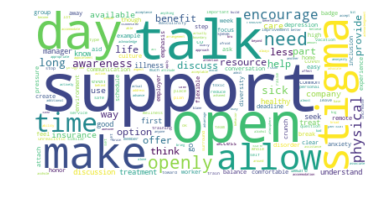

In [65]:
# Pulling out the list of parsed words and put them into a wordcloud
list_of_words = slcv.vocabulary_.keys()
list_of_words = list(list_of_words)
list_of_words.sort()

wordcloud = WordCloud(background_color="white").generate(" ".join(list_of_words))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

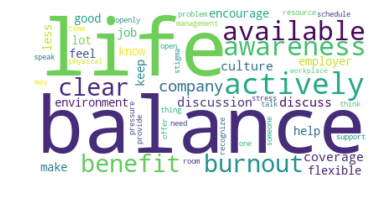

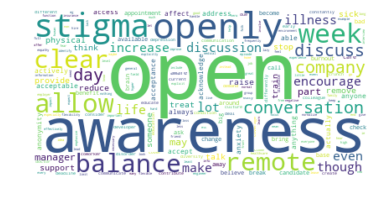

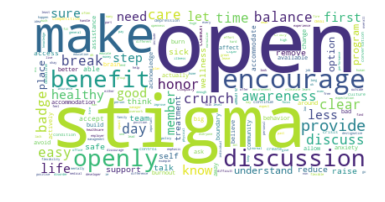

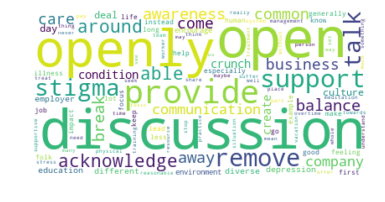

In [66]:
for num in range(4):

    table = table_q4[table_q4.iloc[:,-1]==num]

    # CountVectorizer with SpaCy Lemmatization
    spp = SpacyPipeProcessor(nlp, n_threads=1, multi_iters=True)
    spacy_docs = spp(table.iloc[:,0]);

    slcv = SpacyLemmaCountVectorizer(min_df=3,stop_words=stopwords, ngram_range=(1, 3), ignore_chars='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    slcv.fit(spacy_docs)
    count_vectors = slcv.transform(spacy_docs); count_vectors

    # Pulling out the list of parsed words and put them into a wordcloud
    list_of_words = slcv.vocabulary_.keys()
    list_of_words = list(list_of_words)
    list_of_words.sort()

    wordcloud = WordCloud(background_color="white").generate(" ".join(list_of_words))

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();

In [67]:
# use RNN to do something with the words?